# The %Peak Model
In this notebook we analyse the growth of cases/deaths by country and region. We start with a common model, which we will called the `%Peak` model, which models daily cases/deaths as a fraction of the max cases/deaths per day.

In [162]:
import altair as alt
from matplotlib.pylab import plt
import matplotlib.colors as mcolors
from matplotlib.ticker import LogFormatter 


import pandas as pd
import numpy as np

import seaborn as sns
import altair as alt

import datetime 

import pycountry
import geopandas as gpd
import os

%matplotlib inline

# The Master Dataset
We use the standard Our World in Data Dataset

In [163]:
master_dataset = '../data/processed/master_covid.csv'

df = pd.read_csv(master_dataset, parse_dates=['date'])
df.shape

(25058, 90)

In [164]:
df.head()

,country,country_id,date,country_code,continent,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,...,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay,apple_mobility_drop,apple_rolling_mobility_drop
0,Afghanistan,AF,2019-12-31,AFG,Asia,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AF,2020-01-01,AFG,Asia,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,Afghanistan,AF,2020-01-02,AFG,Asia,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,Afghanistan,AF,2020-01-03,AFG,Asia,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,Afghanistan,AF,2020-01-04,AFG,Asia,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


## Some Filtering

In [165]:
# Focus on countries with >1M population
# df = df[df['population']>1000000]

# Exclude <0 cases/deaths
check_cols = df.filter(regex='_cases|_deaths').columns

df[check_cols] = df[check_cols].clip(lower=0)

df[check_cols].min()

df.shape, df.country.nunique()

((25058, 90), 207)

# The %Peak Model
This model is based on relative daily cases/deaths. Simply put, for a given sequence of cases/deaths, we identify the max and use this to normalise each of the daily values. In this way the relative values will be between 0 and 1.

## Plot %Peak Model

### Plot a single model

In [166]:
def plot_peak_model(ax, data, country):
    
    # Calculate the max and relative data
    peak, total = data.max(), data.sum()
    
    rel = data/peak
    
    # The start and end date of the graph
    start, end = datetime.date(2020, 1, 1), datetime.date.today()
    
    # The colour map to use
    transition_colours = ['c', 'green', 'yellow', 'orange', 'red']
    cmap = mcolors.LinearSegmentedColormap.from_list("", transition_colours)
    colours = [cmap(v) for v in rel.values]

    # Plot the coloured bar chart and the outline line.
    ax.bar(rel.index, rel, color=colours, width=1)
    ax.plot(rel.index, rel, lw=1.5, c='k')

    # Finalise the axes and add a title.
    ax.set_xlim(start, end)
    ax.set_ylim(-0.1, 1)

    ax.axis('off')
    ax.axhline(0, c='k', lw=1)
    
    ax.annotate('{}\nPeak ~ {:,}\nTotal ~ {:,}'.format(country, int(peak), int(total)), xy=(0, .5), xycoords='axes fraction')
    
#     for transition in np.arange(0, 1, 1/len(transition_colours))+1/(2*len(transition_colours)):
#         ax.axhline(transition, lw=.25, ls='--', c='k')
    


In [167]:
transition_colours = ['c', 'green', 'yellow', 'orange', 'red']

np.arange(0, 1, 1/len(transition_colours))+1/(2*len(transition_colours))

array([0.1, 0.3, 0.5, 0.7, 0.9])

### Plot a sequence of models 

In [168]:
def plot_peak_models(axs, df, group='country', col='new_cases_rolling_mean', width=15, height=1):

    # Aggregate the daily values based on the grouping
    values_for_dates = df.groupby([group, 'date']).apply(
        lambda g: g.set_index('date')[col].sum()
    )

    # Get the peak dates based on grouping and sort
    peak_dates = values_for_dates.groupby(group).apply(
        lambda g: g.idxmax()[1]
    ).sort_values()
    
    for ax, label in zip(axs, peak_dates.index):
        plot_peak_model(ax, values_for_dates.loc[label].dropna(), label)

## Sample Graphs

### Global Cases

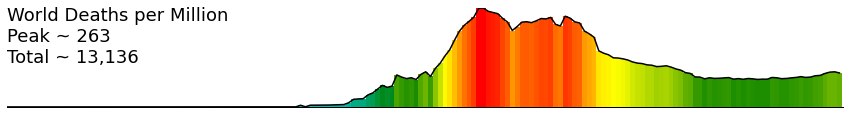

In [169]:
sns.set_context('talk')

fig, ax = plt.subplots(figsize=(15, 2))

world_new_cases_rolling_mean = df.groupby('date')['new_deaths_per_million_rolling_mean'].sum()

plot_peak_model(ax, world_new_cases_rolling_mean.dropna(), 'World Deaths per Million')

fig.savefig("../graphs/world_deaths_per_million_pct_peak_model.png", dpi=300, format='png')

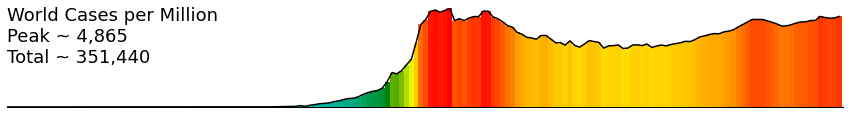

In [170]:
sns.set_context('talk')

fig, ax = plt.subplots(figsize=(15, 2))

world_new_cases_rolling_mean = df.groupby('date')['new_cases_per_million_rolling_mean'].sum()

plot_peak_model(ax, world_new_cases_rolling_mean.dropna(), 'World Cases per Million')

fig.savefig("../graphs/world_cases_per_million_pct_peak_model.png", dpi=300, format='png')

### UK vs Ireland

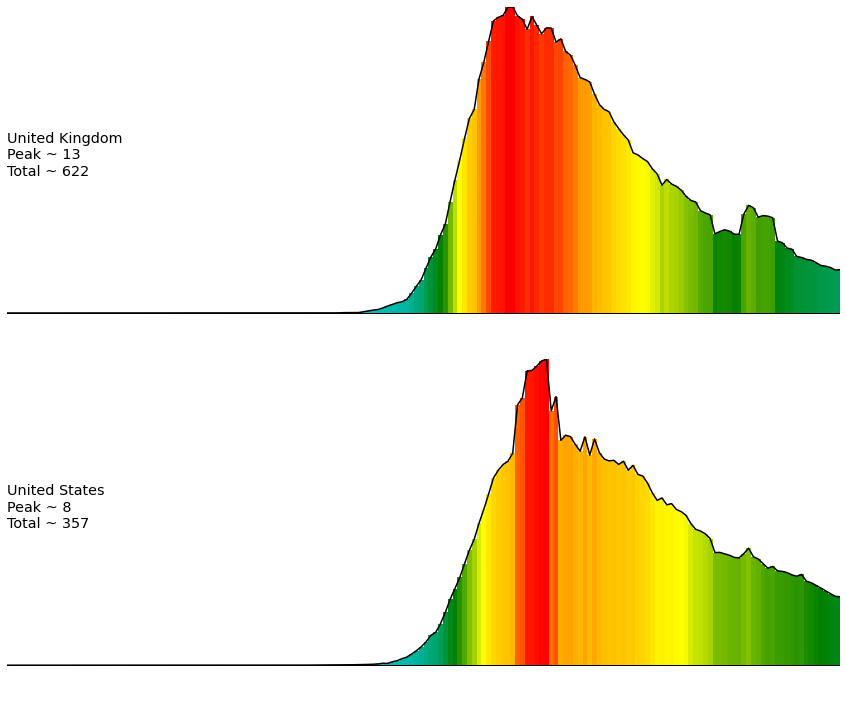

In [159]:
sns.set_context('paper', font_scale=1.5)

# The data col (cases/deaths) and the grouping (country/continent). 
col = 'new_deaths_per_million_rolling_mean'
grouping = 'country'

# Mask groupings without >0 for the data col
grouping_with_col = df.groupby(grouping)[col].max()>0
data = df[(df['country'].isin(['United Kingdom', 'United States'])) & (df[grouping].isin(grouping_with_col[grouping_with_col].index))]

# The graph settings
height = 5                    # The height of each graph
n = data[grouping].nunique()  # The number of rows

# Plot the graphs
fig, axs = plt.subplots(figsize=(12, n*height), nrows=n)

plot_peak_models(axs, data, group=grouping, col=col)

fig.tight_layout()

## Top-Level Regions

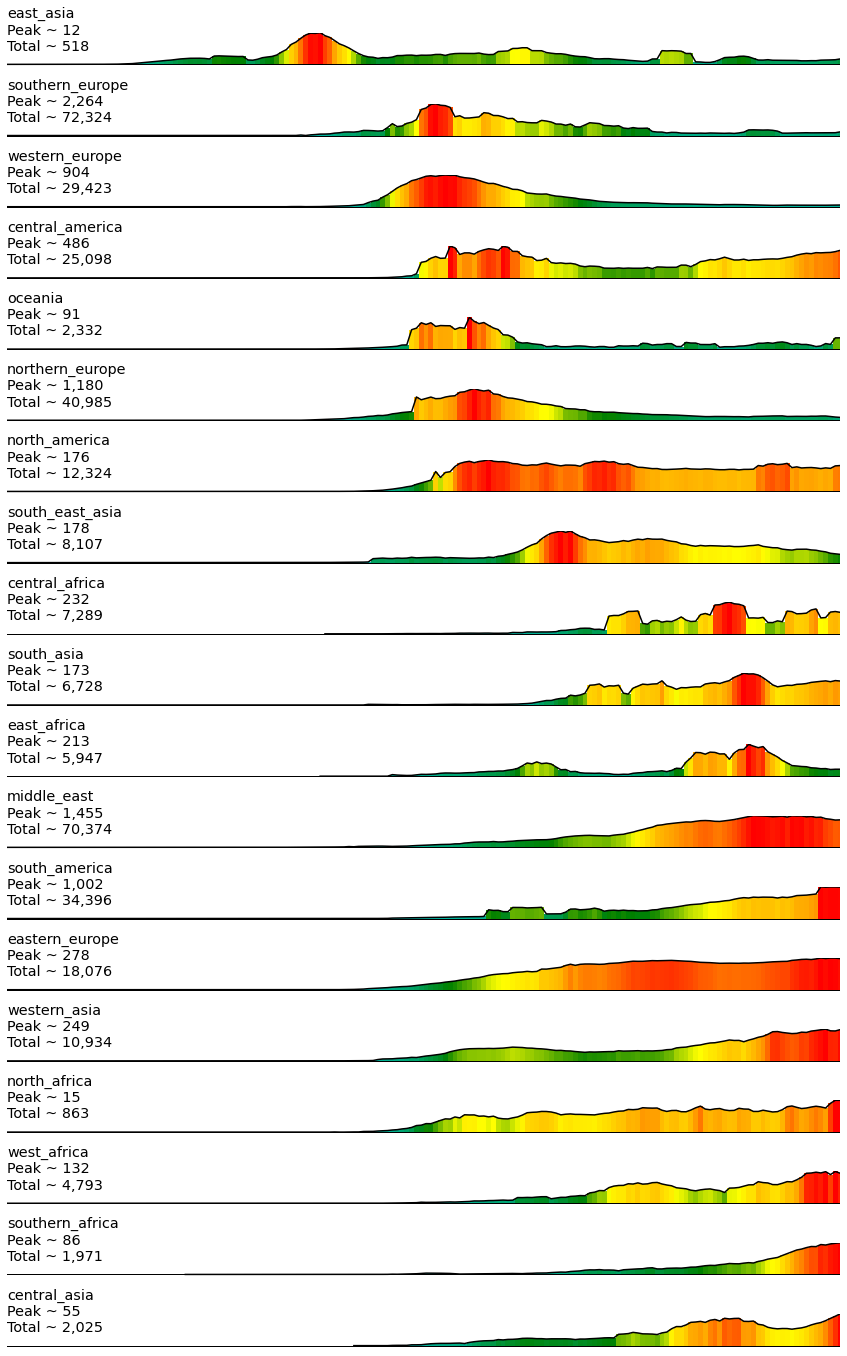

In [160]:
sns.set_context('paper', font_scale=1.5)

# The data col (cases/deaths) and the grouping (country/continent). 
col = 'new_cases_per_million_rolling_mean'
grouping = 'region'

# Mask groupings without >k for the data col
grouping_with_col = df.groupby(grouping)[col].max()>0
data = df[df[grouping].isin(grouping_with_col[grouping_with_col].index)]

# The graph settings
height = 1                    # The height of each graph
n = data[grouping].nunique()  # The number of rows

# Plot the graphs
fig, axs = plt.subplots(figsize=(12, n*height), nrows=n)

plot_peak_models(axs, data, group=grouping, col=col)

fig.tight_layout()

fig.savefig("../graphs/regions_cases_per_million_pct_peak_model.png", dpi=300, format='png')

### EEA

In [161]:
# sns.set_context('paper', font_scale=1.5)

# # The data col (cases/deaths) and the grouping (country/continent). 
# col = 'new_cases_per_million_rolling_mean'
# grouping = 'country'

# # Mask groupings without >k for the data col
# grouping_with_col = df.groupby(grouping)[col].max()>0
# data = df[(df['region']=='eea') & (df[grouping].isin(grouping_with_col[grouping_with_col].index))]

# # The graph settings
# height = 1                    # The height of each graph
# n = data[grouping].nunique()  # The number of rows

# # Plot the graphs
# fig, axs = plt.subplots(figsize=(12, n*height), nrows=n)

# plot_peak_models(axs, data, group=grouping, col=col)

# fig.tight_layout()

# fig.savefig("../graphs/eea_cases_per_million_pct_peak_model.png", dpi=300, format='png')

ValueError: figure size must be positive finite not (12, 0)

### Countries >3m

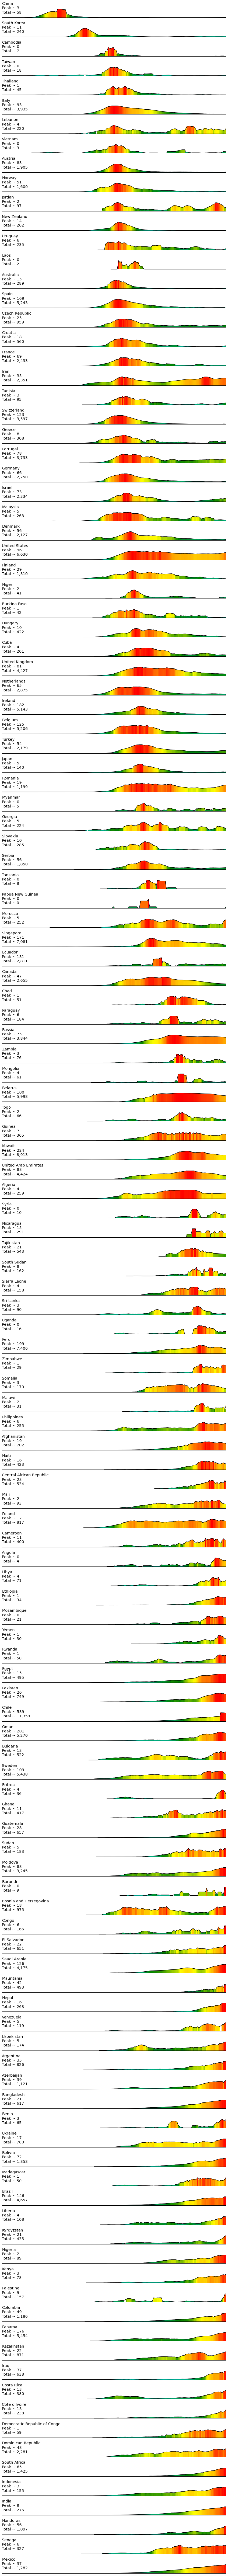

In [107]:
sns.set_context('paper', font_scale=1.5)

# The data col (cases/deaths) and the grouping (country/continent). 
col = 'new_cases_per_million_rolling_mean'
grouping = 'country'

# Mask groupings without >0 for the data col
grouping_with_col = df.groupby(grouping)[col].max()>0
data = df[(df['population']>3000000) & (df[grouping].isin(grouping_with_col[grouping_with_col].index))]


# The graph settings
height = 1                    # The height of each graph
n = data[grouping].nunique()  # The number of rows

# Plot the graphs
fig, axs = plt.subplots(figsize=(12, n*height), nrows=n)

plot_peak_models(axs, data, group=grouping, col=col)

fig.tight_layout()

fig.savefig("../graphs/large_countries_cases_per_million_pct_peak_model.png", dpi=300, format='png')

# Choropleth Maps

## Load the Shapefile

In [110]:
shapefile = '../data/raw/UIA_World_Countries_Boundaries-shp/World_Countries__Generalized_.shp'
gdf = gpd.read_file(shapefile).to_crs('+proj=robin').rename(columns={
    'COUNTRY': 'country',
    'ISO': 'country_id',
}).set_index('country_id')

gdf.sample(5)

,FID,country,COUNTRYAFF,AFF_ISO,SHAPE_Leng,SHAPE_Area,geometry
country_id,,,,,,,
TL,217,Timor-Leste,Timor-Leste,TL,7.719551,1.236304,(POLYGON ((11986961.07141602 -899427.787103570...
CW,41,Curacao,Netherlands,NL,1.160393,0.039249,POLYGON ((-6452838.371489558 1287730.358351794...
PN,6,Pitcairn,United Kingdom,GB,0.338167,0.004286,(POLYGON ((-11814115.94737895 -2601850.7773284...
NC,220,New Caledonia,France,FR,12.571871,1.640599,(POLYGON ((15424086.64581241 -2395609.29194156...
SY,151,Syria,Syria,SY,22.535537,18.570606,"POLYGON ((3199128.278095591 3552184.85922994, ..."


## Add the data to plot

### Add Totals

In [111]:
cols = ['total_deaths', 'total_cases', 'total_deaths_per_million', 'total_cases_per_million']

totals = df.groupby('country_id')[cols].last()

totals.loc['IE']

total_deaths                 1715.000
total_cases                 25379.000
total_deaths_per_million      347.321
total_cases_per_million      5139.743
Name: IE, dtype: float64

In [112]:
gdf = gdf.join(totals)
gdf.head()

,FID,country,COUNTRYAFF,AFF_ISO,SHAPE_Leng,SHAPE_Area,geometry,total_deaths,total_cases,total_deaths_per_million,total_cases_per_million
country_id,,,,,,,,,,,
AD,154,Andorra,Andorra,AD,0.937352,0.055585,"POLYGON ((124141.1672733102 4552185.155729871,...",52.0,855.0,673.008,11065.812
AE,207,United Arab Emirates,United Arab Emirates,AE,16.759676,6.239850,(POLYGON ((5176069.830196898 2718833.131786438...,302.0,44925.0,30.535,4542.283
AF,192,Afghanistan,Afghanistan,AF,50.803210,62.566714,"POLYGON ((5443894.20188662 3808194.404713432, ...",581.0,28833.0,14.925,740.669
AG,29,Antigua and Barbuda,Antigua and Barbuda,AG,1.162901,0.045626,(POLYGON ((-5757571.193631138 1817081.01004422...,3.0,26.0,30.635,265.501
AI,28,Anguilla,United Kingdom,GB,0.468389,0.007798,"POLYGON ((-5879780.8172767 1942719.530662017, ...",0.0,3.0,0.000,199.973


### Add the Cases/Deaths Data

In [113]:
cols = ['new_deaths_rolling_mean', 'new_cases_rolling_mean', 'new_deaths_per_million_rolling_mean', 'new_cases_per_million_rolling_mean']

latest_data = df.set_index('country_id').groupby('country_id')[cols].last().rename(columns={
    col: 'current_'+col for col in cols
})

latest_rel_data = df.set_index(['country_id', 'date']).groupby('country_id')[cols].apply(
    lambda n: n/n.max()
).groupby('country_id').last().rename(columns={
    col: 'rel_'+col for col in latest_data.columns
})

latest_rel_data.tail()

,new_deaths_rolling_mean,new_cases_rolling_mean,new_deaths_per_million_rolling_mean,new_cases_per_million_rolling_mean
country_id,,,,
VN,NaN,0.161290,NaN,0.161257
YE,0.800000,0.583562,8.000519e-01,0.583592
ZA,0.922131,1.000000,9.222168e-01,1.000000
ZM,0.000000,0.143713,6.395294e-17,0.143727
ZW,1.000000,0.706667,1.000000e+00,0.706698


In [114]:
gdf = gdf.join(latest_data).join(latest_rel_data)
gdf.head()

,FID,country,COUNTRYAFF,AFF_ISO,SHAPE_Leng,SHAPE_Area,geometry,total_deaths,total_cases,total_deaths_per_million,total_cases_per_million,current_new_deaths_rolling_mean,current_new_cases_rolling_mean,current_new_deaths_per_million_rolling_mean,current_new_cases_per_million_rolling_mean,new_deaths_rolling_mean,new_cases_rolling_mean,new_deaths_per_million_rolling_mean,new_cases_per_million_rolling_mean
country_id,,,,,,,,,,,,,,,,,,,
AD,154,Andorra,Andorra,AD,0.937352,0.055585,"POLYGON ((124141.1672733102 4552185.155729871,...",52.0,855.0,673.008,11065.812,0.142857,0.285714,1.848857,3.697714,0.071429,0.008439,0.071426,0.008439
AE,207,United Arab Emirates,United Arab Emirates,AE,16.759676,6.239850,(POLYGON ((5176069.830196898 2718833.131786438...,302.0,44925.0,30.535,4542.283,1.857143,375.857143,0.187571,38.002143,0.180556,0.429411,0.180382,0.429410
AF,192,Afghanistan,Afghanistan,AF,50.803210,62.566714,"POLYGON ((5443894.20188662 3808194.404713432, ...",581.0,28833.0,14.925,740.669,15.714286,581.000000,0.403571,14.924857,0.802920,0.765913,0.803013,0.765910
AG,29,Antigua and Barbuda,Antigua and Barbuda,AG,1.162901,0.045626,(POLYGON ((-5757571.193631138 1817081.01004422...,3.0,26.0,30.635,265.501,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AI,28,Anguilla,United Kingdom,GB,0.468389,0.007798,"POLYGON ((-5879780.8172767 1942719.530662017, ...",0.0,3.0,0.000,199.973,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000


### Days Past Peaks

In [115]:
new_cases_peak_dates = df.set_index('date').groupby('country_id')['new_cases_per_million_rolling_mean'].apply(
    lambda cases: cases.idxmax()
)

days_past_new_cases_peak = pd.DataFrame(
    (df.groupby('country_id')['date'].max()-new_cases_peak_dates).map(lambda td: td.days),
    columns=['days_past_new_cases_peak']
)

days_past_new_cases_peak.head()

,days_past_new_cases_peak
country_id,
AD,83
AE,28
AF,16
AG,73
AI,81


In [116]:
new_deaths_peak_dates = df.set_index('date').groupby('country_id')['new_deaths_per_million_rolling_mean'].apply(
    lambda deaths: deaths.idxmax()
)

days_past_new_deaths_peak = pd.DataFrame(
    (df.groupby('country_id')['date'].max()-new_deaths_peak_dates).map(lambda td: td.days),
    columns=['days_past_new_deaths_peak']
)

days_past_new_deaths_peak.head()

,days_past_new_deaths_peak
country_id,
AD,81
AE,42
AF,9
AG,73
AI,81


In [117]:
gdf = gdf.join(days_past_new_cases_peak).join(days_past_new_deaths_peak)
gdf.head()

,FID,country,COUNTRYAFF,AFF_ISO,SHAPE_Leng,SHAPE_Area,geometry,total_deaths,total_cases,total_deaths_per_million,...,current_new_deaths_rolling_mean,current_new_cases_rolling_mean,current_new_deaths_per_million_rolling_mean,current_new_cases_per_million_rolling_mean,new_deaths_rolling_mean,new_cases_rolling_mean,new_deaths_per_million_rolling_mean,new_cases_per_million_rolling_mean,days_past_new_cases_peak,days_past_new_deaths_peak
country_id,,,,,,,,,,,,,,,,,,,,,
AD,154,Andorra,Andorra,AD,0.937352,0.055585,"POLYGON ((124141.1672733102 4552185.155729871,...",52.0,855.0,673.008,...,0.142857,0.285714,1.848857,3.697714,0.071429,0.008439,0.071426,0.008439,83.0,81.0
AE,207,United Arab Emirates,United Arab Emirates,AE,16.759676,6.239850,(POLYGON ((5176069.830196898 2718833.131786438...,302.0,44925.0,30.535,...,1.857143,375.857143,0.187571,38.002143,0.180556,0.429411,0.180382,0.429410,28.0,42.0
AF,192,Afghanistan,Afghanistan,AF,50.803210,62.566714,"POLYGON ((5443894.20188662 3808194.404713432, ...",581.0,28833.0,14.925,...,15.714286,581.000000,0.403571,14.924857,0.802920,0.765913,0.803013,0.765910,16.0,9.0
AG,29,Antigua and Barbuda,Antigua and Barbuda,AG,1.162901,0.045626,(POLYGON ((-5757571.193631138 1817081.01004422...,3.0,26.0,30.635,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,73.0,73.0
AI,28,Anguilla,United Kingdom,GB,0.468389,0.007798,"POLYGON ((-5879780.8172767 1942719.530662017, ...",0.0,3.0,0.000,...,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,81.0,81.0


### Day's past 75% Peak

In [118]:
today = datetime.datetime.today()
today

datetime.datetime(2020, 6, 22, 19, 12, 58, 805948)

In [119]:
peak_cases = df.groupby('country_id')['new_cases_per_million_rolling_mean'].max()*.75

days_past_cases_75_pct_peak = pd.DataFrame(
    df.set_index('date').groupby(
        'country_id')['new_cases_per_million_rolling_mean'].apply(
            lambda g: (today-g[g>peak_cases.loc[g.name]].iloc[::-1].index[0]).days if len(g[g>peak_cases.loc[g.name]])>0 else np.nan
    ).fillna(0),
).rename(columns={'new_cases_per_million_rolling_mean':'days_past_new_cases_75_pct_peak'})

days_past_cases_75_pct_peak.mean()

days_past_new_cases_75_pct_peak    35.309179
dtype: float64

In [120]:
peak_deaths = df.groupby('country_id')['new_deaths_per_million_rolling_mean'].max()*.75

days_past_deaths_75_pct_peak = pd.DataFrame(
    df.set_index('date').groupby(
        'country_id')['new_deaths_per_million_rolling_mean'].apply(
            lambda g: (today-g[g>peak_deaths.loc[g.name]].iloc[::-1].index[0]).days if len(g[g>peak_deaths.loc[g.name]])>0 else np.nan
    ).fillna(0),
).rename(columns={'new_deaths_per_million_rolling_mean':'days_past_new_deaths_75_pct_peak'})

days_past_deaths_75_pct_peak.mean()

days_past_new_deaths_75_pct_peak    30.545894
dtype: float64

In [121]:
gdf = gdf.join(days_past_cases_75_pct_peak).join(days_past_deaths_75_pct_peak)
gdf.head()

,FID,country,COUNTRYAFF,AFF_ISO,SHAPE_Leng,SHAPE_Area,geometry,total_deaths,total_cases,total_deaths_per_million,...,current_new_deaths_per_million_rolling_mean,current_new_cases_per_million_rolling_mean,new_deaths_rolling_mean,new_cases_rolling_mean,new_deaths_per_million_rolling_mean,new_cases_per_million_rolling_mean,days_past_new_cases_peak,days_past_new_deaths_peak,days_past_new_cases_75_pct_peak,days_past_new_deaths_75_pct_peak
country_id,,,,,,,,,,,,,,,,,,,,,
AD,154,Andorra,Andorra,AD,0.937352,0.055585,"POLYGON ((124141.1672733102 4552185.155729871,...",52.0,855.0,673.008,...,1.848857,3.697714,0.071429,0.008439,0.071426,0.008439,83.0,81.0,80.0,70.0
AE,207,United Arab Emirates,United Arab Emirates,AE,16.759676,6.239850,(POLYGON ((5176069.830196898 2718833.131786438...,302.0,44925.0,30.535,...,0.187571,38.002143,0.180556,0.429411,0.180382,0.429410,28.0,42.0,19.0,40.0
AF,192,Afghanistan,Afghanistan,AF,50.803210,62.566714,"POLYGON ((5443894.20188662 3808194.404713432, ...",581.0,28833.0,14.925,...,0.403571,14.924857,0.802920,0.765913,0.803013,0.765910,16.0,9.0,0.0,0.0
AG,29,Antigua and Barbuda,Antigua and Barbuda,AG,1.162901,0.045626,(POLYGON ((-5757571.193631138 1817081.01004422...,3.0,26.0,30.635,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,73.0,73.0,67.0,67.0
AI,28,Anguilla,United Kingdom,GB,0.468389,0.007798,"POLYGON ((-5879780.8172767 1942719.530662017, ...",0.0,3.0,0.000,...,0.000000,0.000000,NaN,0.000000,NaN,0.000000,81.0,81.0,81.0,0.0


### Add SI data

In [122]:
si_totals = df.groupby('country_id')[['stringency_index']].sum().rename(columns={'stringency_index':'stringency_index_total'})

si_peaks = df.groupby('country_id')[['stringency_index']].max().rename(columns={'stringency_index':'stringency_index_max'})


si_totals.loc['ES']

stringency_index_total    7688.03
Name: ES, dtype: float64

In [123]:
gdf = gdf.join(si_totals).join(si_peaks)
gdf.head()

,FID,country,COUNTRYAFF,AFF_ISO,SHAPE_Leng,SHAPE_Area,geometry,total_deaths,total_cases,total_deaths_per_million,...,new_deaths_rolling_mean,new_cases_rolling_mean,new_deaths_per_million_rolling_mean,new_cases_per_million_rolling_mean,days_past_new_cases_peak,days_past_new_deaths_peak,days_past_new_cases_75_pct_peak,days_past_new_deaths_75_pct_peak,stringency_index_total,stringency_index_max
country_id,,,,,,,,,,,,,,,,,,,,,
AD,154,Andorra,Andorra,AD,0.937352,0.055585,"POLYGON ((124141.1672733102 4552185.155729871,...",52.0,855.0,673.008,...,0.071429,0.008439,0.071426,0.008439,83.0,81.0,80.0,70.0,4280.61,56.48
AE,207,United Arab Emirates,United Arab Emirates,AE,16.759676,6.239850,(POLYGON ((5176069.830196898 2718833.131786438...,302.0,44925.0,30.535,...,0.180556,0.429411,0.180382,0.429410,28.0,42.0,19.0,40.0,7396.21,89.81
AF,192,Afghanistan,Afghanistan,AF,50.803210,62.566714,"POLYGON ((5443894.20188662 3808194.404713432, ...",581.0,28833.0,14.925,...,0.802920,0.765913,0.803013,0.765910,16.0,9.0,0.0,0.0,6743.53,84.26
AG,29,Antigua and Barbuda,Antigua and Barbuda,AG,1.162901,0.045626,(POLYGON ((-5757571.193631138 1817081.01004422...,3.0,26.0,30.635,...,0.000000,0.000000,0.000000,0.000000,73.0,73.0,67.0,67.0,0.00,NaN
AI,28,Anguilla,United Kingdom,GB,0.468389,0.007798,"POLYGON ((-5879780.8172767 1942719.530662017, ...",0.0,3.0,0.000,...,NaN,0.000000,NaN,0.000000,81.0,81.0,81.0,0.0,0.00,NaN


### Add Testing Data

In [124]:
test_totals = df.groupby('country_id')[['new_tests_smoothed', 'new_tests_smoothed_per_thousand']].sum().rename(
    columns={
        'new_tests_smoothed':'total_tests',
        'new_tests_smoothed_per_thousand':'total_tests_per_million',
    })

test_totals['total_tests_per_million'] = test_totals['total_tests_per_million']*1000

test_totals.loc['IE']

total_tests                374913.0
total_tests_per_million     75927.0
Name: IE, dtype: float64

In [125]:
gdf = gdf.join(test_totals)
gdf.head()

,FID,country,COUNTRYAFF,AFF_ISO,SHAPE_Leng,SHAPE_Area,geometry,total_deaths,total_cases,total_deaths_per_million,...,new_deaths_per_million_rolling_mean,new_cases_per_million_rolling_mean,days_past_new_cases_peak,days_past_new_deaths_peak,days_past_new_cases_75_pct_peak,days_past_new_deaths_75_pct_peak,stringency_index_total,stringency_index_max,total_tests,total_tests_per_million
country_id,,,,,,,,,,,,,,,,,,,,,
AD,154,Andorra,Andorra,AD,0.937352,0.055585,"POLYGON ((124141.1672733102 4552185.155729871,...",52.0,855.0,673.008,...,0.071426,0.008439,83.0,81.0,80.0,70.0,4280.61,56.48,0.0,0.0
AE,207,United Arab Emirates,United Arab Emirates,AE,16.759676,6.239850,(POLYGON ((5176069.830196898 2718833.131786438...,302.0,44925.0,30.535,...,0.180382,0.429410,28.0,42.0,19.0,40.0,7396.21,89.81,0.0,0.0
AF,192,Afghanistan,Afghanistan,AF,50.803210,62.566714,"POLYGON ((5443894.20188662 3808194.404713432, ...",581.0,28833.0,14.925,...,0.803013,0.765910,16.0,9.0,0.0,0.0,6743.53,84.26,0.0,0.0
AG,29,Antigua and Barbuda,Antigua and Barbuda,AG,1.162901,0.045626,(POLYGON ((-5757571.193631138 1817081.01004422...,3.0,26.0,30.635,...,0.000000,0.000000,73.0,73.0,67.0,67.0,0.00,NaN,0.0,0.0
AI,28,Anguilla,United Kingdom,GB,0.468389,0.007798,"POLYGON ((-5879780.8172767 1942719.530662017, ...",0.0,3.0,0.000,...,NaN,0.000000,81.0,81.0,81.0,0.0,0.00,NaN,0.0,0.0


## Plot the Map

In [126]:
cmap = mcolors.LinearSegmentedColormap.from_list("", ['green', 'yellow', 'orange', 'red'])

def plot_map(ax, gdf, col='total_cases_per_million', normalizer='log', cmap=cmap, min_value=0):
    
    gdf[col] = gdf[col].clip(min_value)
    
    if normalizer is 'log':
        norm = mcolors.LogNorm(vmin=max(min_value, gdf[col].min()), vmax=gdf[col].max())
    else:
        norm = mcolors.Normalize(vmin=gdf[col].min(), vmax=gdf[col].max())

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

    gdf.drop('AQ').boundary.plot(color='k', ax=ax, lw=.5)
    gdf.drop('AQ').plot(
        column=col, cmap=cmap, norm=norm, ax=ax, 
        missing_kwds = dict(color = "lightgrey",))


    if normalizer is 'log':
        formatter = LogFormatter(10, labelOnlyBase=False) 
        cbar = plt.colorbar(sm, format=formatter)
    else:
        cbar = plt.colorbar(sm)


    cbar.set_label(col.replace('_', ' ').title())

    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.set_facecolor('lightblue')


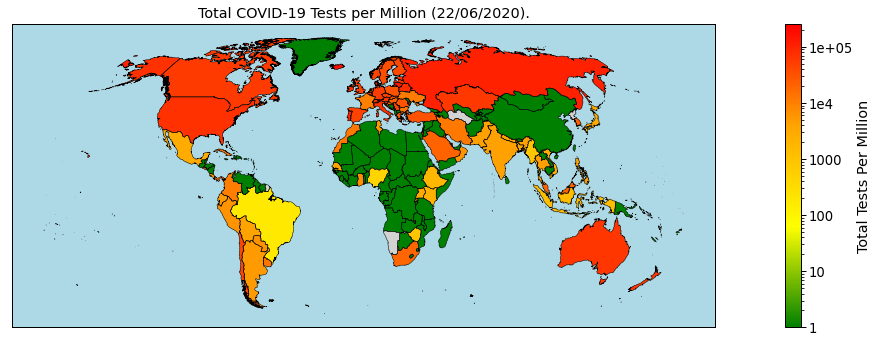

In [127]:
fig, ax = plt.subplots(figsize=(20, 5))

plot_map(ax, gdf, col='total_tests_per_million', normalizer='log', min_value=1)

ax.set_title('Total COVID-19 Tests per Million ({}).'.format(
    datetime.datetime.today().strftime("%d/%m/%Y")))

fig.tight_layout()



### Total Cases per Million

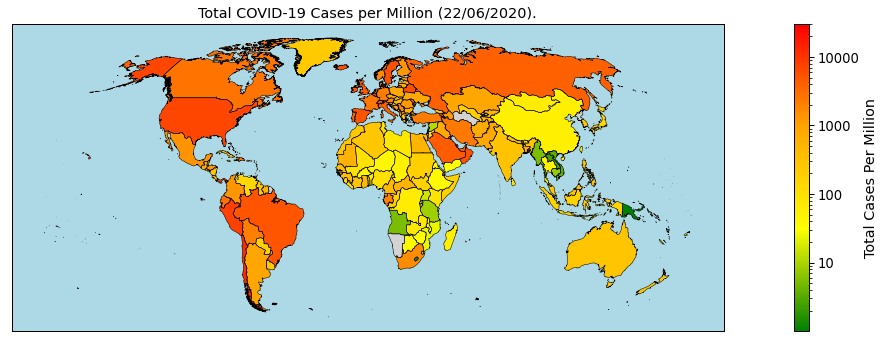

In [128]:
fig, ax = plt.subplots(figsize=(20, 5))

plot_map(ax, gdf, col='total_cases_per_million', min_value=1)

ax.set_title('Total COVID-19 Cases per Million ({}).'.format(
    datetime.datetime.today().strftime("%d/%m/%Y")))

fig.tight_layout()

fig.savefig("../graphs/total_cases_per_million_map.png", dpi=300, format='png')

### Total Deaths per Million

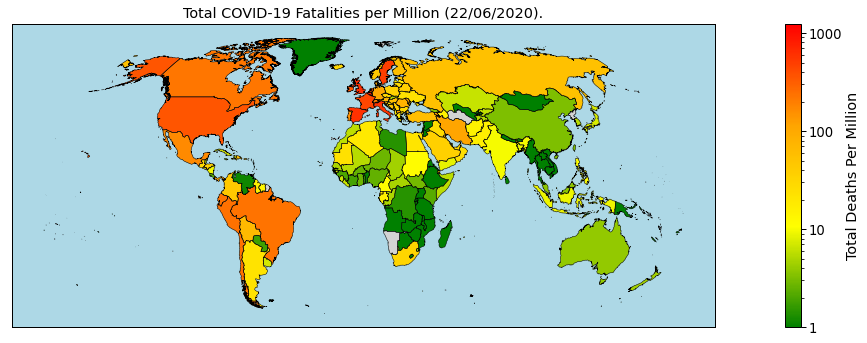

In [129]:
fig, ax = plt.subplots(figsize=(20, 5))

plot_map(ax, gdf, col='total_deaths_per_million', min_value=1)

ax.set_title('Total COVID-19 Fatalities per Million ({}).'.format(
    datetime.datetime.today().strftime("%d/%m/%Y")))


fig.tight_layout()

fig.savefig("../graphs/total_deaths_per_million_map.png", dpi=300, format='png')

### Total SI

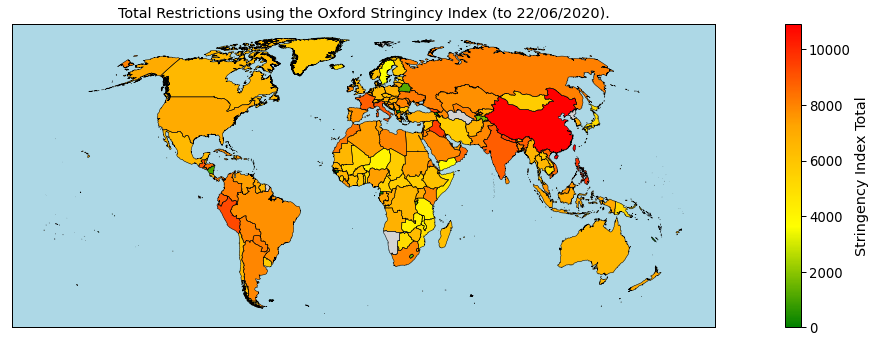

In [130]:
fig, ax = plt.subplots(figsize=(20, 5))

plot_map(ax, gdf, col='stringency_index_total', normalizer='linear', min_value=0)

ax.set_title('Total Restrictions using the Oxford Stringincy Index (to {}).'.format(
    datetime.datetime.today().strftime("%d/%m/%Y")))


fig.tight_layout()

fig.savefig("../graphs/total_si_map.png", dpi=300, format='png')

### Max SI

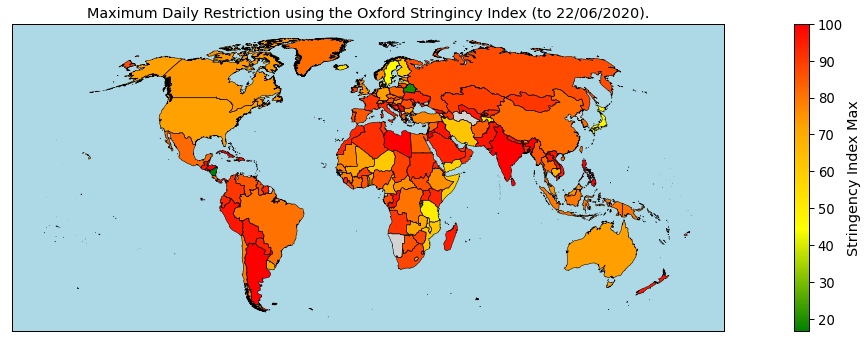

In [131]:
fig, ax = plt.subplots(figsize=(20, 5))

plot_map(ax, gdf, col='stringency_index_max', normalizer='linear')

ax.set_title('Maximum Daily Restriction using the Oxford Stringincy Index (to {}).'.format(
    datetime.datetime.today().strftime("%d/%m/%Y")))


fig.tight_layout()

### Days Past 75% Peak

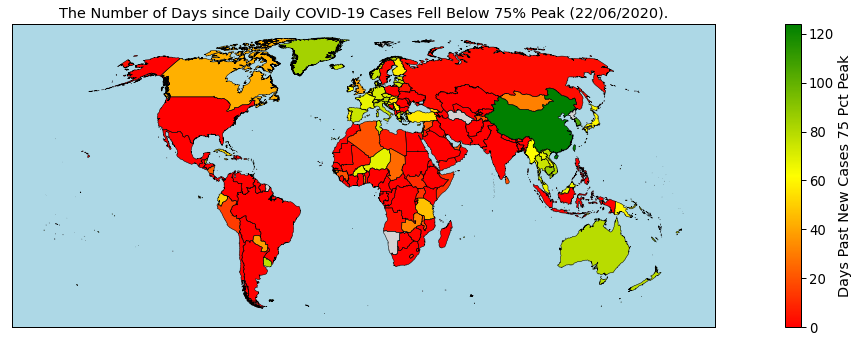

In [132]:
reverse_cmap = mcolors.LinearSegmentedColormap.from_list("", ['green', 'yellow', 'red']).reversed()

fig, ax = plt.subplots(figsize=(20, 5))

plot_map(ax, gdf, col='days_past_new_cases_75_pct_peak', normalizer='linear', cmap=reverse_cmap)

ax.set_title('The Number of Days since Daily COVID-19 Cases Fell Below 75% Peak ({}).'.format(
    datetime.datetime.today().strftime("%d/%m/%Y")))

fig.tight_layout()

fig.savefig("../graphs/days_after_cases_75_pct_peak_map.png", dpi=300, format='png')

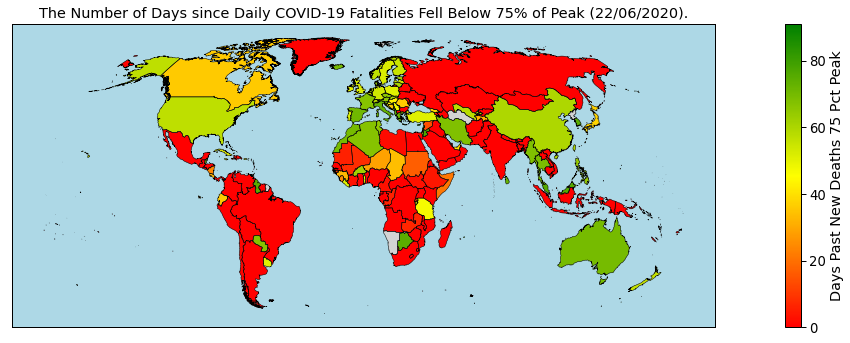

In [133]:
reverse_cmap = mcolors.LinearSegmentedColormap.from_list("", ['green', 'yellow', 'red']).reversed()

fig, ax = plt.subplots(figsize=(20, 5))

plot_map(ax, gdf, col='days_past_new_deaths_75_pct_peak', normalizer='linear', cmap=reverse_cmap)

ax.set_title('The Number of Days since Daily COVID-19 Fatalities Fell Below 75% of Peak ({}).'.format(
    datetime.datetime.today().strftime("%d/%m/%Y")))

fig.tight_layout()

fig.savefig("../graphs/days_after_deaths_75_pct_peak_map.png", dpi=300, format='png')

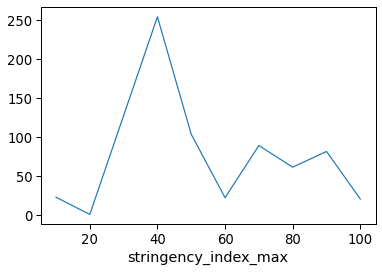

In [138]:
gdf.groupby(gdf['stringency_index_max']//10*10)['total_deaths_per_million'].mean().plot()

In [ ]:
p = df.groupby('country').last()[['total_deaths', 'population']]
p.head()

In [ ]:
p['pop_share'] = p['population']/p['population'].sum()
p['cases_share'] = p['total_deaths']/p['total_deaths'].sum()

p['case_ratio'] = p['cases_share']/p['pop_share']

In [ ]:
df[df['population']>3000000].groupby('country').last()['total_deaths_per_million'].sort_values(ascending=False)

In [ ]:
p[p['population']>3000000].sort_values(by='case_ratio', ascending=False)['case_ratio']